# **Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_absolute_error

#**Load the dataset**


In [2]:
# Load the dataset
data = pd.read_csv('jena_climate_2009_2016.csv')
data['Date Time'] = pd.to_datetime(data['Date Time'], format='%d.%m.%Y %H:%M:%S', dayfirst=True)
data.set_index('Date Time', inplace=True)

# **Select a target variable**

In [3]:
# Select a target variable
target_column = 'T (degC)'
data = data[target_column]

# **Data Analysis Plots**


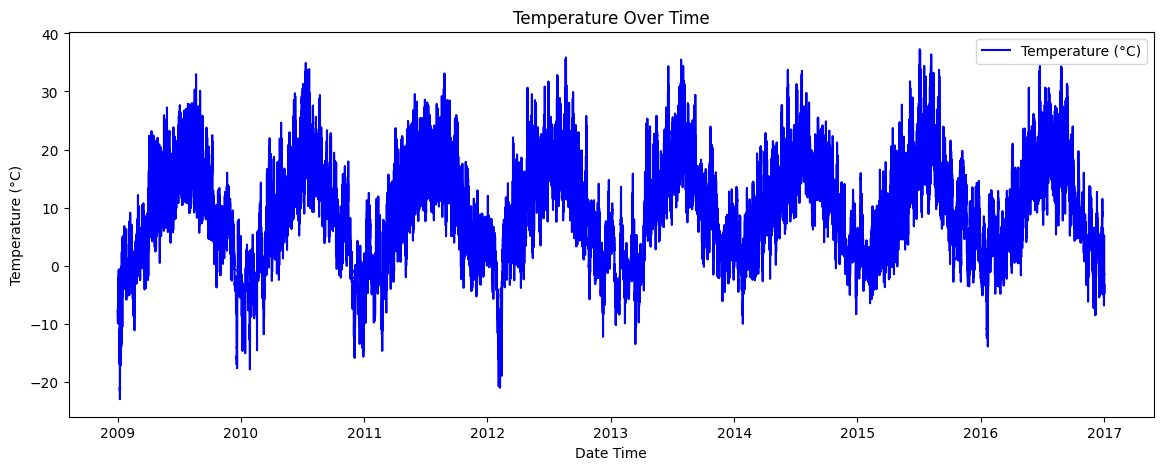

In [4]:
# Data Analysis Plots
# 1. Time Series Plot
plt.figure(figsize=(14, 5))
plt.plot(data.index, data, label='Temperature (°C)', color='blue')
plt.title('Temperature Over Time')
plt.xlabel('Date Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

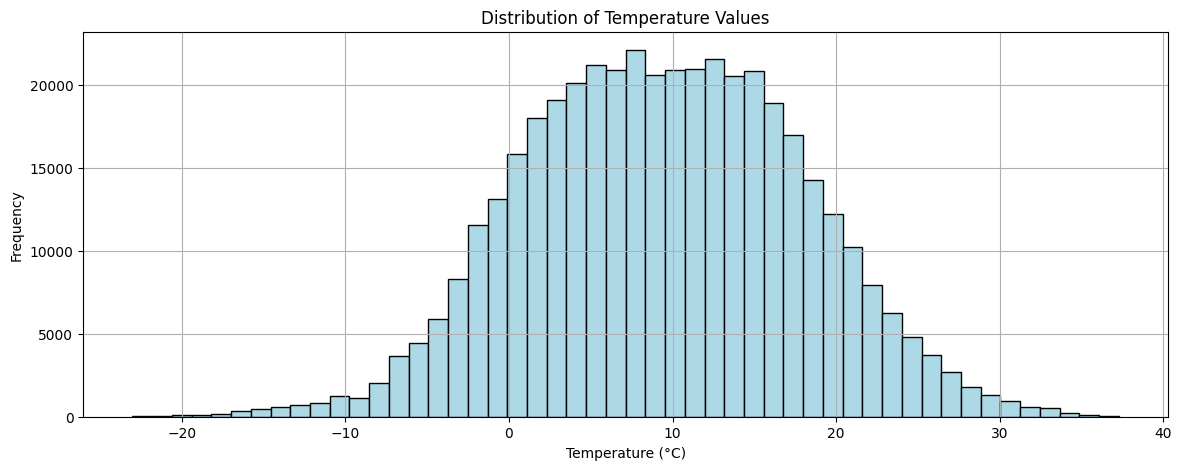

In [5]:
# 2. Histogram
plt.figure(figsize=(14, 5))
plt.hist(data, bins=50, color='lightblue', edgecolor='black')
plt.title('Distribution of Temperature Values')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.grid()
plt.show()


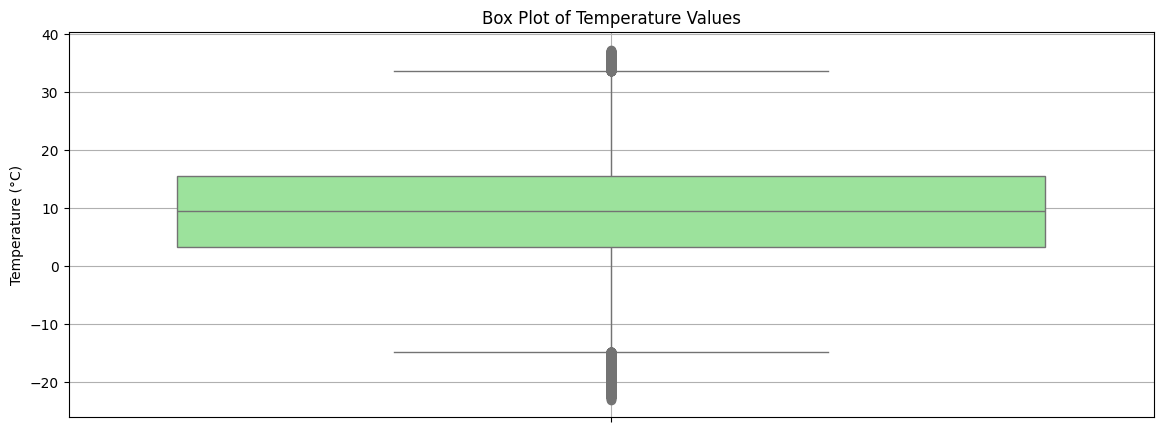

In [6]:
# 3. Box Plot
plt.figure(figsize=(14, 5))
sns.boxplot(data=data, color='lightgreen')
plt.title('Box Plot of Temperature Values')
plt.ylabel('Temperature (°C)')
plt.grid()
plt.show()

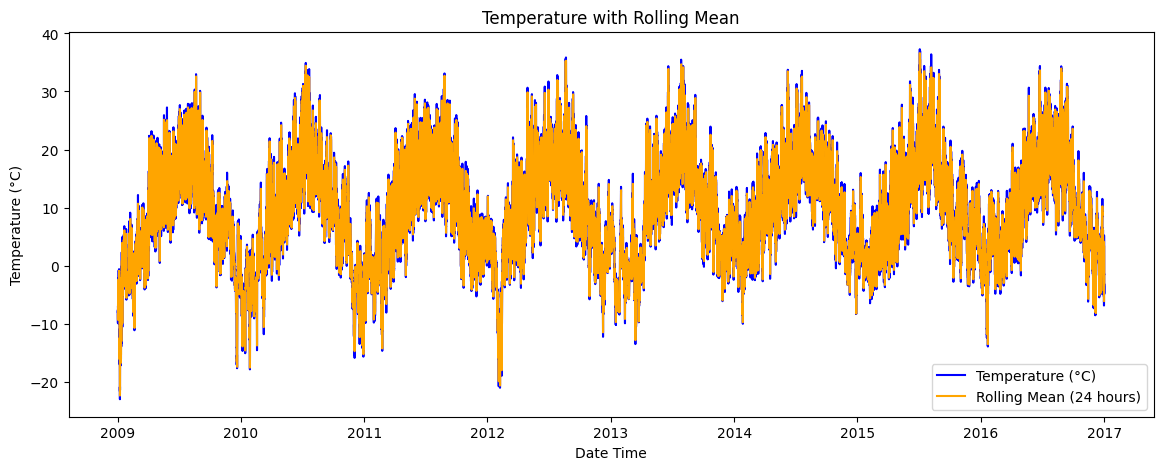

In [7]:
# 4. Rolling Mean
rolling_mean = data.rolling(window=24).mean()
plt.figure(figsize=(14, 5))
plt.plot(data.index, data, label='Temperature (°C)', color='blue')
plt.plot(data.index, rolling_mean, label='Rolling Mean (24 hours)', color='orange')
plt.title('Temperature with Rolling Mean')
plt.xlabel('Date Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

#**Data Pre processing**

In [8]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data.values.reshape(-1, 1))

In [9]:
# Create sequences for training
def create_sequences(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [10]:
# Define the time step
time_step = 48
X, y = create_sequences(data_scaled, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)


#**Data Splitting**

In [11]:
# Split the dataset into training, validation, and test sets
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)
X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

#**Model Training**

In [12]:
# Function to build and train models
def build_and_train_model(model_name, model):
    print(f"Training {model_name} model...")
    model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)

    # Plot results
    true_values = scaler.inverse_transform(y_test.reshape(-1, 1))

    # True vs Predicted Plot
    plt.figure(figsize=(14, 5))
    plt.plot(data.index[-len(y_test):], true_values, label='True Values', color='blue')
    plt.plot(data.index[-len(predictions):], predictions, label='Predictions', color='orange')
    plt.title(f'{model_name} - Temperature Prediction')
    plt.xlabel('Date Time')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.show()

    # Residual Plot
    residuals = true_values - predictions
    plt.figure(figsize=(14, 5))
    plt.plot(data.index[-len(y_test):], residuals, label='Residuals', color='purple')
    plt.axhline(0, color='black', linestyle='--')
    plt.title(f'{model_name} - Residuals')
    plt.xlabel('Date Time')
    plt.ylabel('Residuals (°C)')
    plt.legend()
    plt.show()

    # Distribution of Residuals
    plt.figure(figsize=(14, 5))
    plt.hist(residuals, bins=50, color='lightblue', edgecolor='black')
    plt.title(f'{model_name} - Distribution of Residuals')
    plt.xlabel('Residuals (°C)')
    plt.ylabel('Frequency')
    plt.grid()
    plt.show()

    # Calculate MAE
    mae = mean_absolute_error(true_values, predictions)
    print(f'{model_name} MAE: {mae:.4f}')
    return mae

In [13]:
# Define and train enhanced models
models = {
    "Bidirectional_LSTM_50": Sequential([
        layers.Bidirectional(layers.LSTM(50, return_sequences=True), input_shape=(X_train.shape[1], 1)),
        layers.Bidirectional(layers.LSTM(50)),
        layers.Dense(1)
    ]),

    "Bidirectional_LSTM_100": Sequential([
        layers.Bidirectional(layers.LSTM(100, return_sequences=True), input_shape=(X_train.shape[1], 1)),
        layers.Bidirectional(layers.LSTM(100)),
        layers.Dense(1)
    ]),

    "Stacked_LSTM_50_50": Sequential([
        layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        layers.LSTM(50, return_sequences=True),
        layers.LSTM(50),
        layers.Dense(1)
    ]),

    "Stacked_LSTM_100_50": Sequential([
        layers.LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        layers.LSTM(50),
        layers.Dense(1)
    ]),

    "Conv_LSTM_50": Sequential([
        layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        layers.MaxPooling1D(pool_size=2),
        layers.LSTM(50),
        layers.Dense(1)
    ]),

    "Conv_LSTM_100": Sequential([
        layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        layers.MaxPooling1D(pool_size=2),
        layers.LSTM(100),
        layers.Dense(1)
    ]),

    "Stacked_Conv_LSTM": Sequential([
        layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        layers.MaxPooling1D(pool_size=2),
        layers.LSTM(50, return_sequences=True),
        layers.LSTM(50),
        layers.Dense(1)
    ]),

    "Advanced_LSTM_with_Dropout": Sequential([
        layers.LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        layers.Dropout(0.2),
        layers.LSTM(50),
        layers.Dense(1)
    ]),

    "Advanced_Bidirectional_LSTM_with_Dropout": Sequential([
        layers.Bidirectional(layers.LSTM(100, return_sequences=True), input_shape=(X_train.shape[1], 1)),
        layers.Dropout(0.2),
        layers.Bidirectional(layers.LSTM(50)),
        layers.Dense(1)
    ])
}

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Bidirectional_LSTM_50 model...
Epoch 1/5
9199/9199 ━━━━━━━━━━━━━━━━━━━━ 132s 14ms/step - loss: 0.0012 - val_loss: 5.3375e-05
Epoch 2/5
9199/9199 ━━━━━━━━━━━━━━━━━━━━ 139s 14ms/step - loss: 2.3356e-05 - val_loss: 1.2361e-05
Epoch 3/5
9199/9199 ━━━━━━━━━━━━━━━━━━━━ 142s 14ms/step - loss: 1.6299e-05 - val_loss: 1.7306e-05
Epoch 4/5
9199/9199 ━━━━━━━━━━━━━━━━━━━━ 125s 14ms/step - loss: 1.5304e-05 - val_loss: 1.3788e-05
Epoch 5/5
9199/9199 ━━━━━━━━━━━━━━━━━━━━ 125s 14ms/step - loss: 1.4943e-05 - val_loss: 1.6129e-05
1972/1972 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step


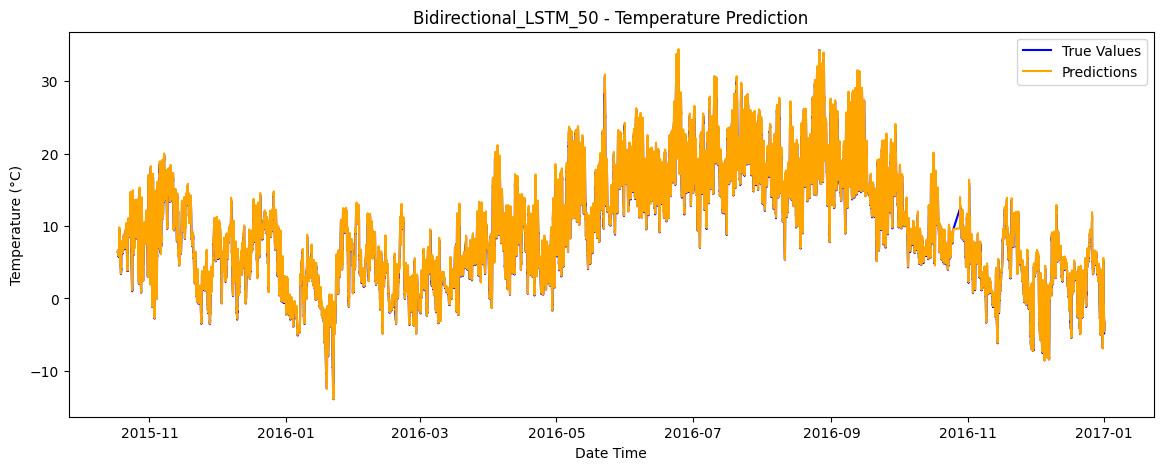

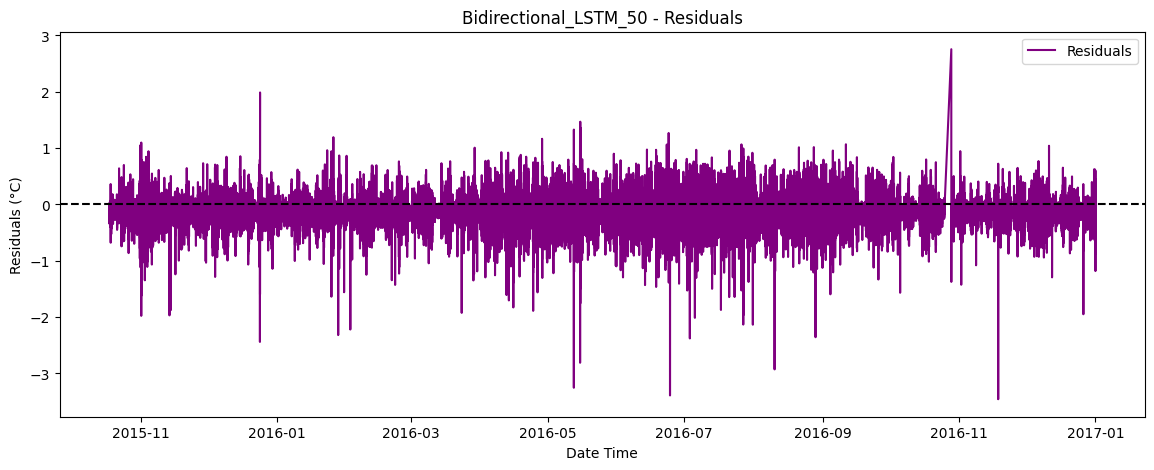

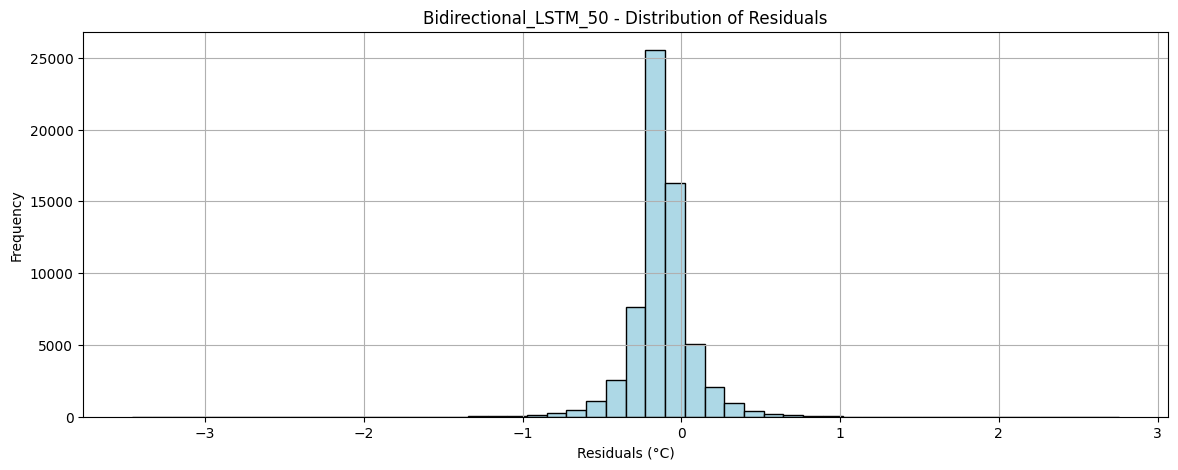

Bidirectional_LSTM_50 MAE: 0.1749
Training Bidirectional_LSTM_100 model...
Epoch 1/5
9199/9199 ━━━━━━━━━━━━━━━━━━━━ 133s 14ms/step - loss: 8.8118e-04 - val_loss: 1.4765e-05
Epoch 2/5
9199/9199 ━━━━━━━━━━━━━━━━━━━━ 142s 14ms/step - loss: 2.0256e-05 - val_loss: 2.1802e-05
Epoch 3/5
9199/9199 ━━━━━━━━━━━━━━━━━━━━ 142s 14ms/step - loss: 1.6521e-05 - val_loss: 1.4544e-05
Epoch 4/5
9199/9199 ━━━━━━━━━━━━━━━━━━━━ 142s 14ms/step - loss: 1.5370e-05 - val_loss: 1.2581e-05
Epoch 5/5
9199/9199 ━━━━━━━━━━━━━━━━━━━━ 131s 14ms/step - loss: 1.4676e-05 - val_loss: 1.2740e-05
1972/1972 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step


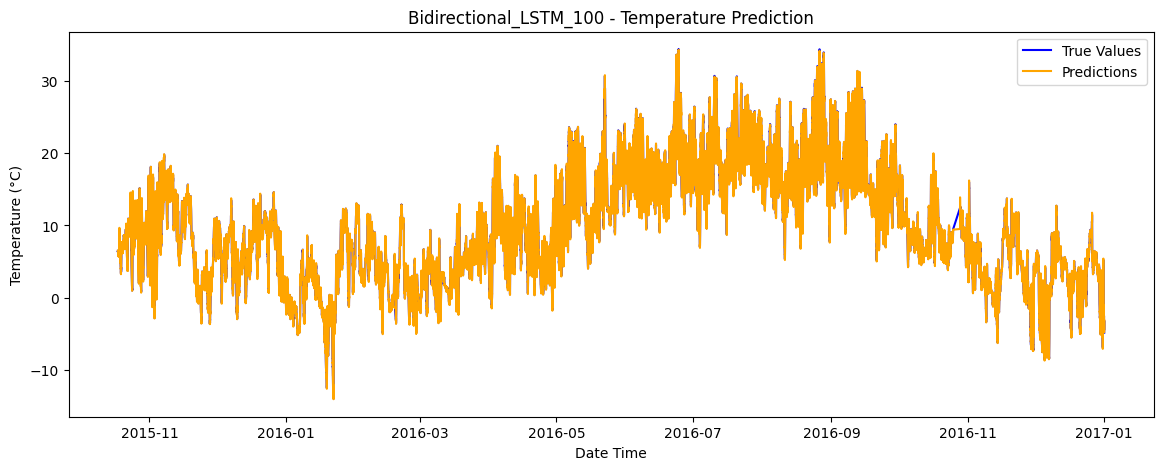

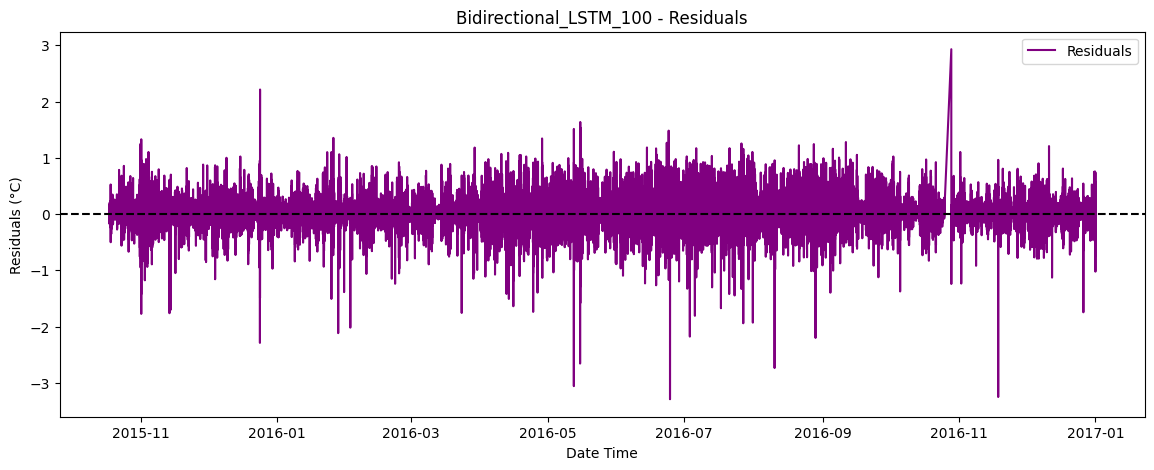

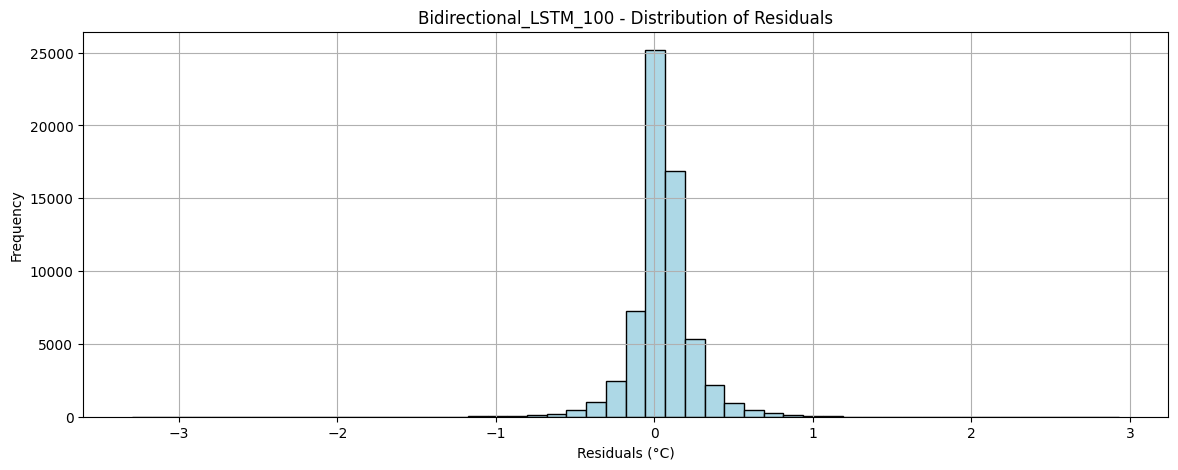

Bidirectional_LSTM_100 MAE: 0.1327
Training Stacked_LSTM_50_50 model...
Epoch 1/5
9199/9199 ━━━━━━━━━━━━━━━━━━━━ 106s 11ms/step - loss: 0.0012 - val_loss: 1.5214e-05
Epoch 2/5
9199/9199 ━━━━━━━━━━━━━━━━━━━━ 104s 11ms/step - loss: 2.1015e-05 - val_loss: 4.8905e-05
Epoch 3/5
9199/9199 ━━━━━━━━━━━━━━━━━━━━ 104s 11ms/step - loss: 1.7043e-05 - val_loss: 1.2252e-05
Epoch 4/5
9199/9199 ━━━━━━━━━━━━━━━━━━━━ 106s 12ms/step - loss: 1.5548e-05 - val_loss: 1.4831e-05
Epoch 5/5
9199/9199 ━━━━━━━━━━━━━━━━━━━━ 103s 11ms/step - loss: 1.5233e-05 - val_loss: 1.9987e-05
1972/1972 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step


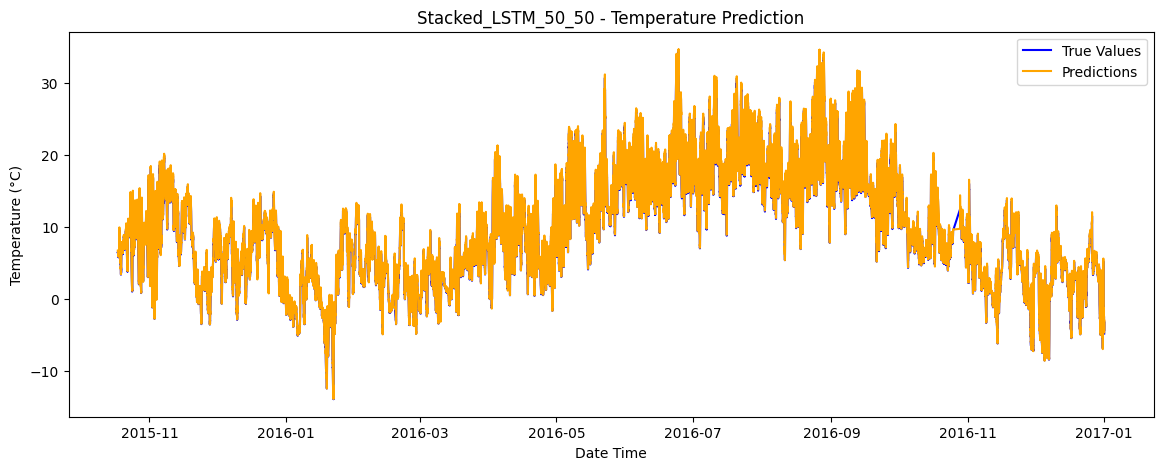

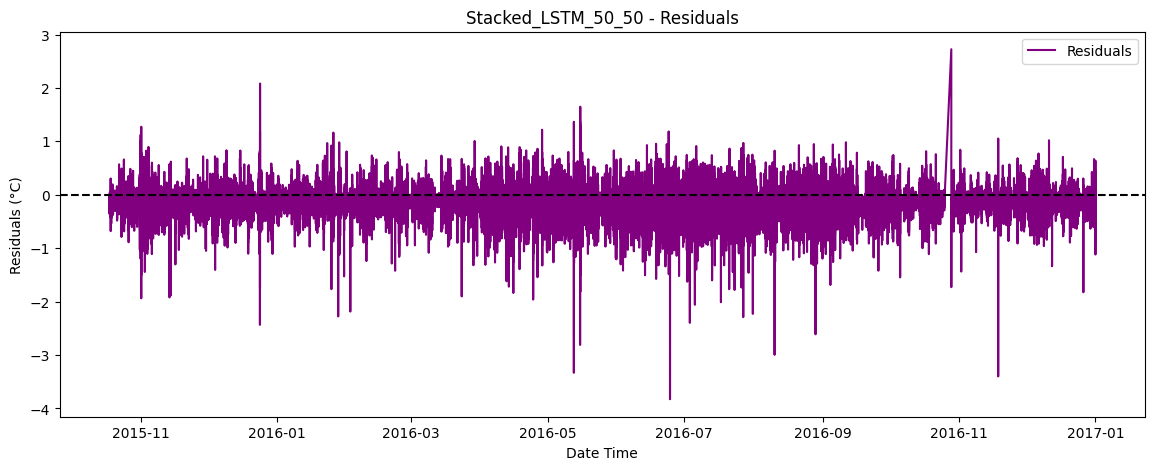

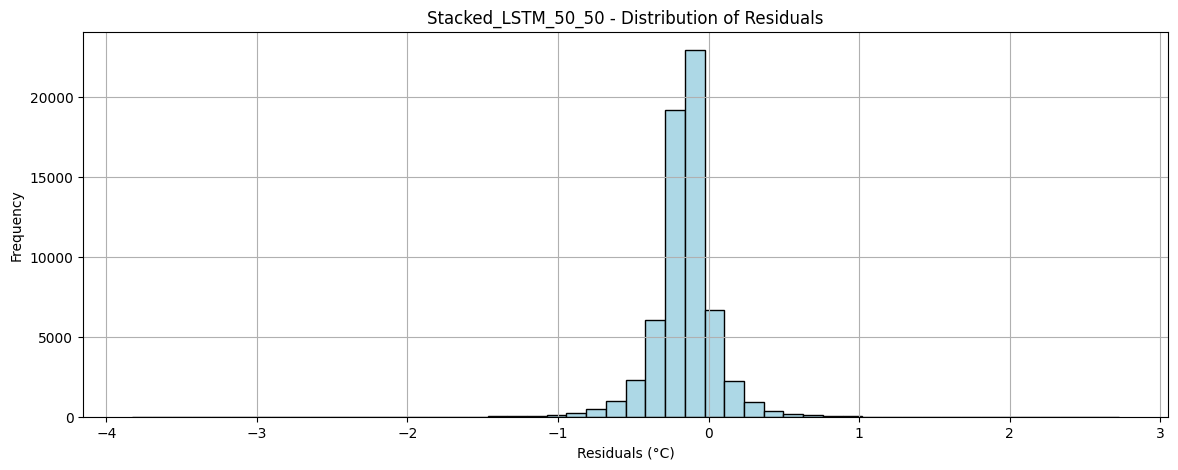

Stacked_LSTM_50_50 MAE: 0.1955
Training Stacked_LSTM_100_50 model...
Epoch 1/5
9199/9199 ━━━━━━━━━━━━━━━━━━━━ 81s 9ms/step - loss: 9.0394e-04 - val_loss: 1.5288e-05
Epoch 2/5
9199/9199 ━━━━━━━━━━━━━━━━━━━━ 82s 9ms/step - loss: 1.8080e-05 - val_loss: 1.5883e-05
Epoch 3/5
9199/9199 ━━━━━━━━━━━━━━━━━━━━ 80s 8ms/step - loss: 1.5874e-05 - val_loss: 1.2578e-05
Epoch 4/5
9199/9199 ━━━━━━━━━━━━━━━━━━━━ 81s 9ms/step - loss: 1.4559e-05 - val_loss: 1.3982e-05
Epoch 5/5
9199/9199 ━━━━━━━━━━━━━━━━━━━━ 81s 9ms/step - loss: 1.4630e-05 - val_loss: 1.9952e-05
1972/1972 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


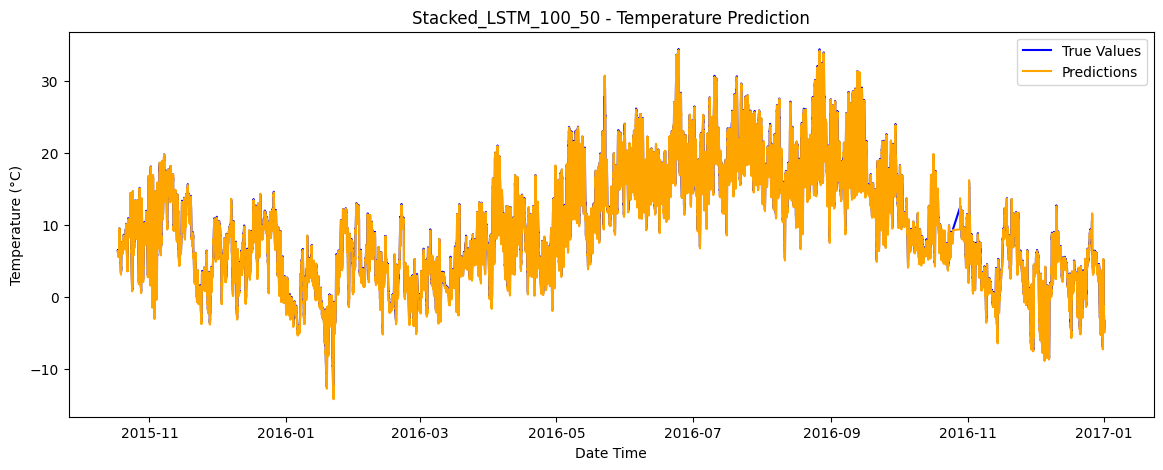

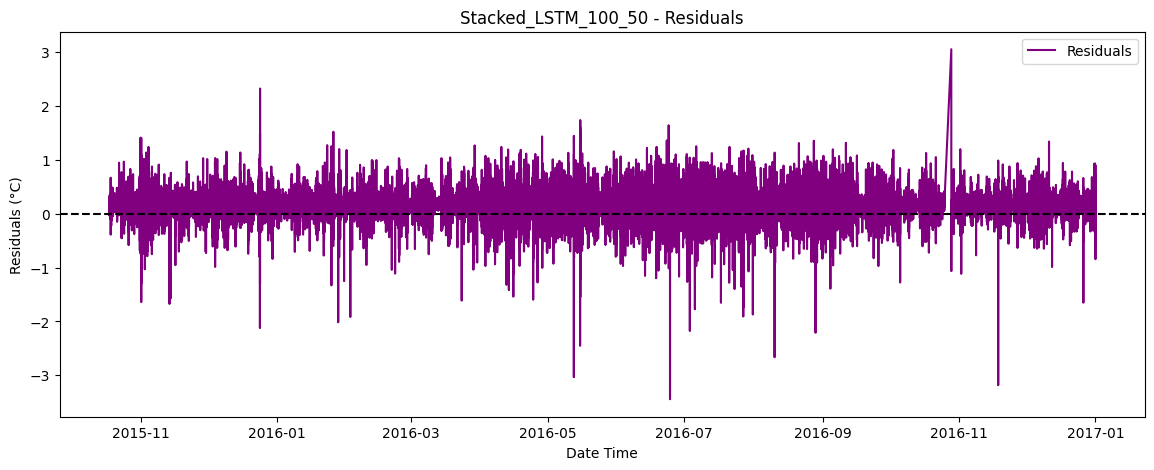

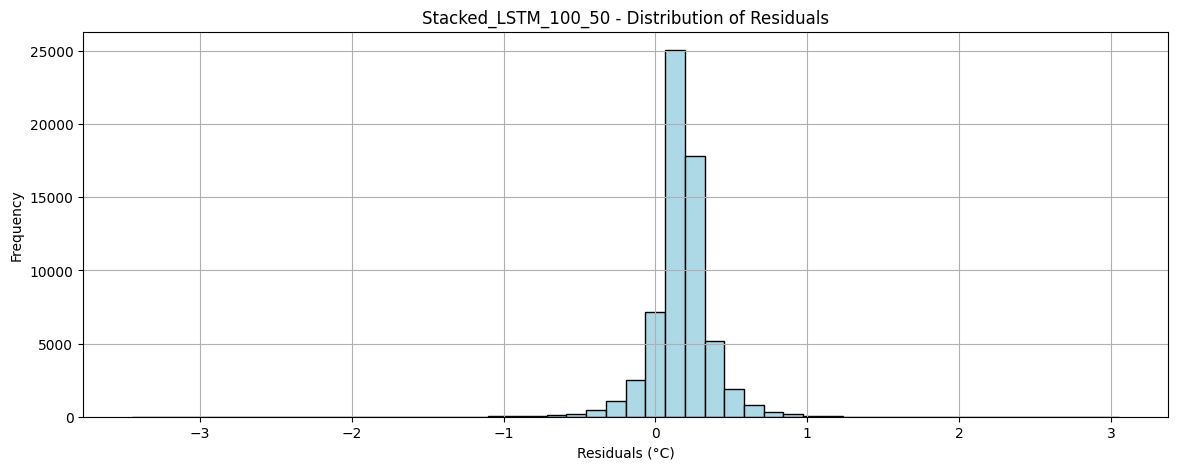

Stacked_LSTM_100_50 MAE: 0.2093
Training Conv_LSTM_50 model...
Epoch 1/5
9199/9199 ━━━━━━━━━━━━━━━━━━━━ 58s 6ms/step - loss: 8.7930e-04 - val_loss: 2.1990e-05
Epoch 2/5
9199/9199 ━━━━━━━━━━━━━━━━━━━━ 54s 6ms/step - loss: 2.8326e-05 - val_loss: 2.0212e-05
Epoch 3/5
9199/9199 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - loss: 2.3102e-05 - val_loss: 2.0023e-05
Epoch 4/5
9199/9199 ━━━━━━━━━━━━━━━━━━━━ 84s 6ms/step - loss: 1.8703e-05 - val_loss: 2.2838e-05
Epoch 5/5
9199/9199 ━━━━━━━━━━━━━━━━━━━━ 80s 6ms/step - loss: 1.7576e-05 - val_loss: 2.2036e-05
1972/1972 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


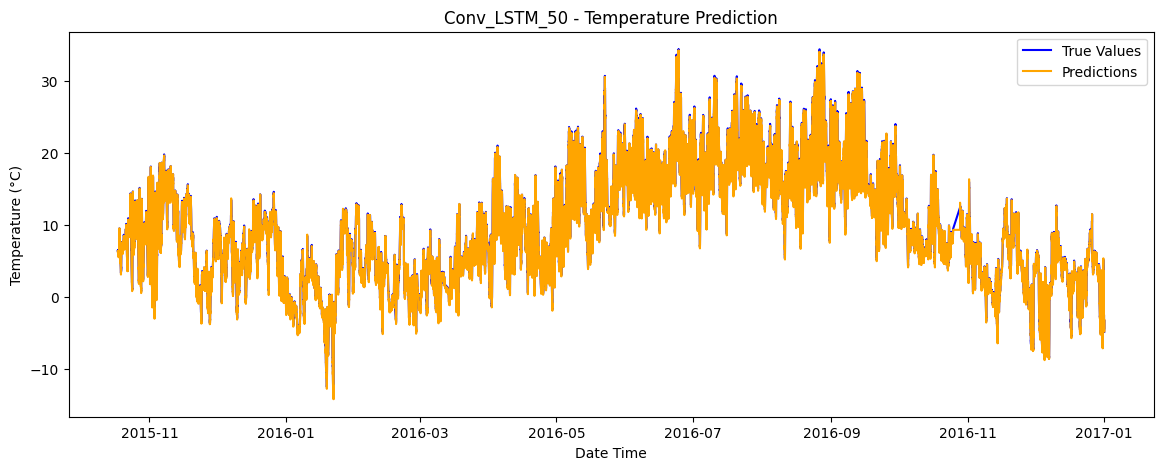

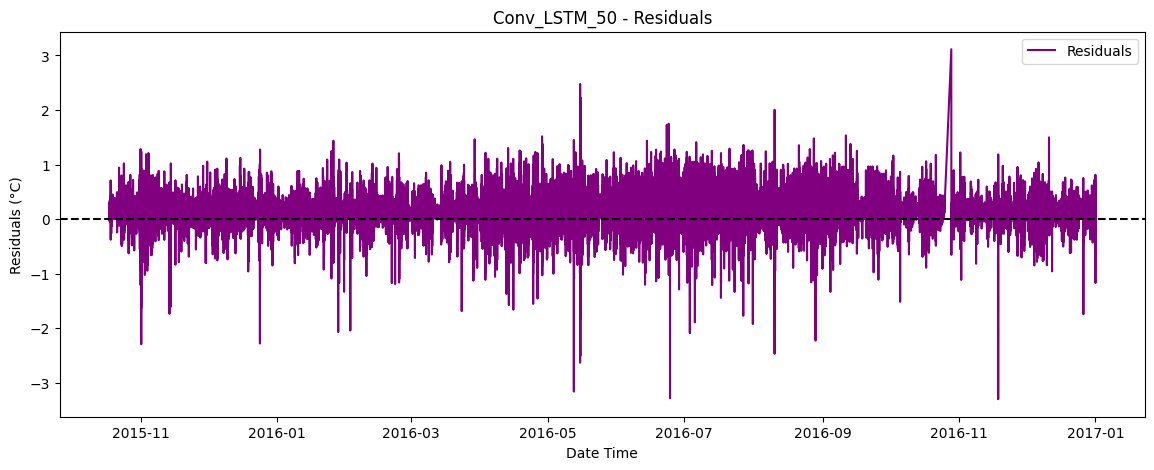

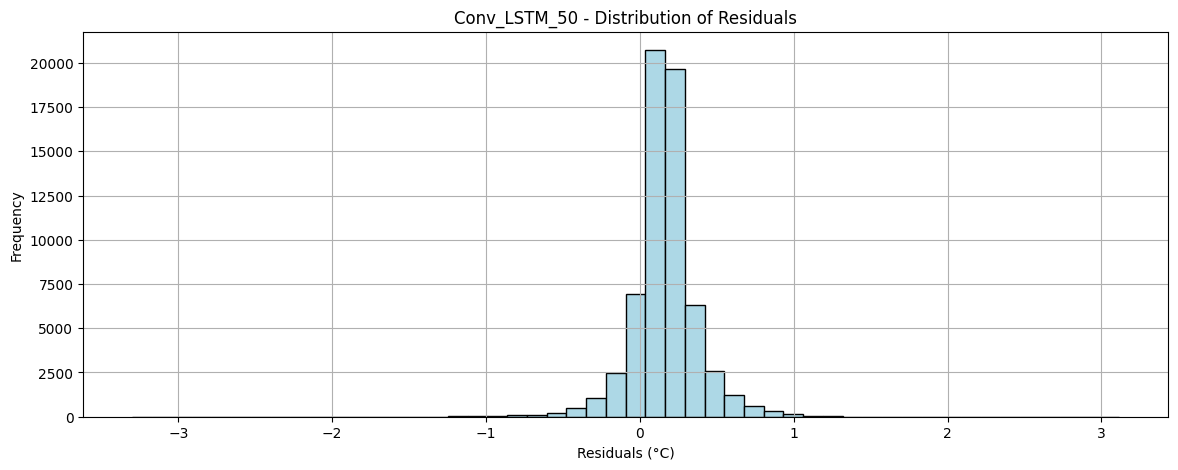

Conv_LSTM_50 MAE: 0.2084
Training Conv_LSTM_100 model...
Epoch 1/5
9199/9199 ━━━━━━━━━━━━━━━━━━━━ 56s 6ms/step - loss: 0.0014 - val_loss: 2.0363e-05
Epoch 2/5
9199/9199 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - loss: 2.6092e-05 - val_loss: 1.7784e-05
Epoch 3/5
9199/9199 ━━━━━━━━━━━━━━━━━━━━ 58s 6ms/step - loss: 2.2489e-05 - val_loss: 1.6751e-05
Epoch 4/5
9199/9199 ━━━━━━━━━━━━━━━━━━━━ 81s 6ms/step - loss: 1.9814e-05 - val_loss: 1.8026e-05
Epoch 5/5
9199/9199 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - loss: 1.9084e-05 - val_loss: 1.4800e-05
1972/1972 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


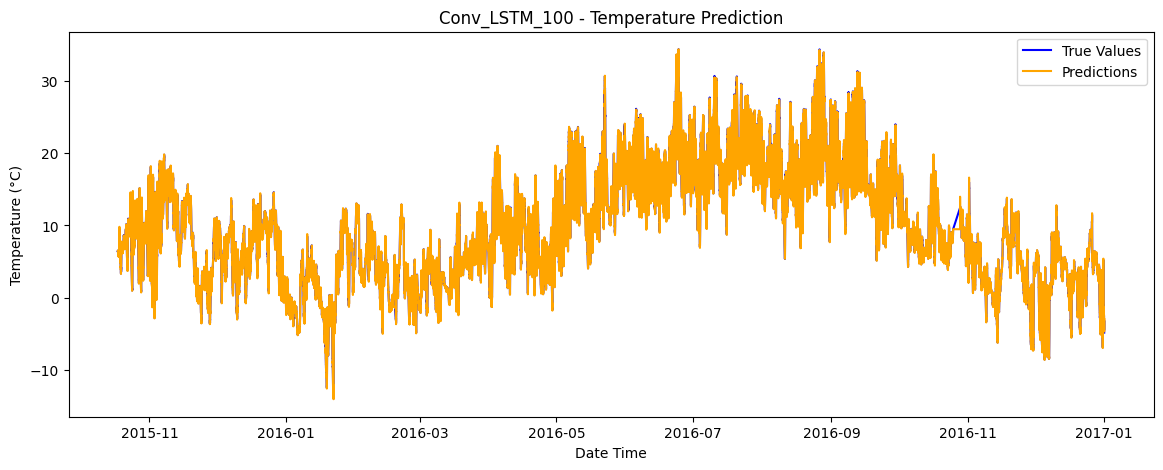

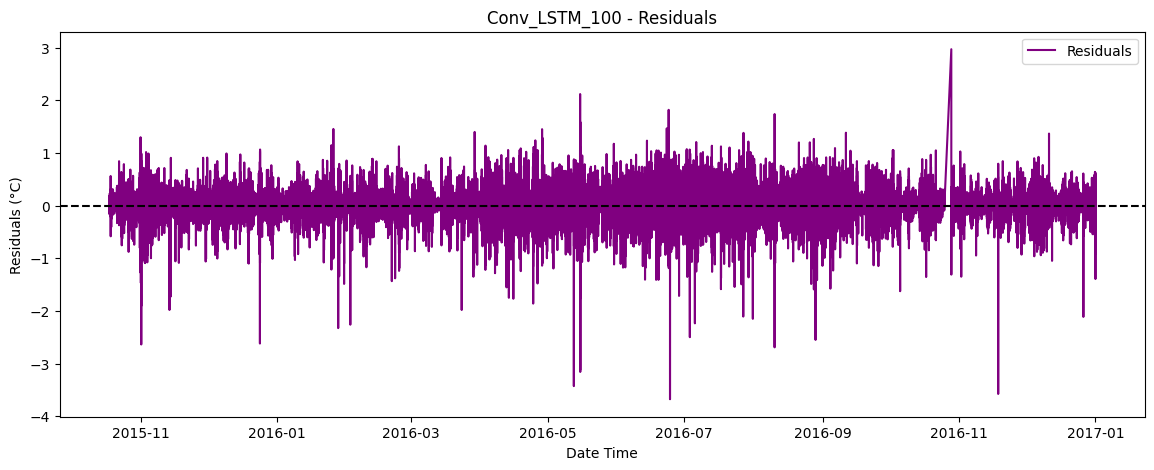

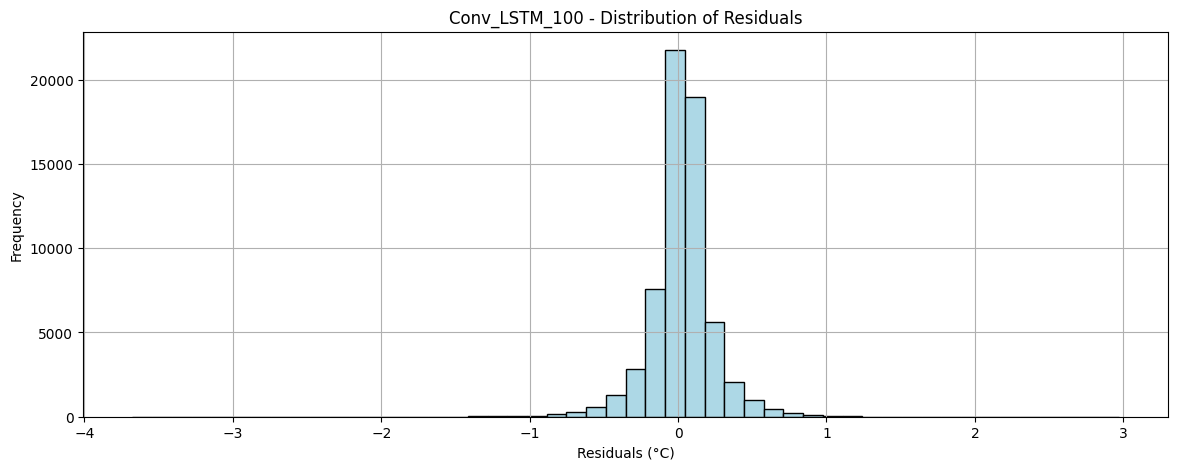

Conv_LSTM_100 MAE: 0.1431
Training Stacked_Conv_LSTM model...
Epoch 1/5
9199/9199 ━━━━━━━━━━━━━━━━━━━━ 77s 8ms/step - loss: 0.0012 - val_loss: 2.5279e-05
Epoch 2/5
9199/9199 ━━━━━━━━━━━━━━━━━━━━ 84s 8ms/step - loss: 2.8347e-05 - val_loss: 1.5515e-05
Epoch 3/5
9199/9199 ━━━━━━━━━━━━━━━━━━━━ 84s 9ms/step - loss: 2.0687e-05 - val_loss: 1.5823e-05
Epoch 4/5
9199/9199 ━━━━━━━━━━━━━━━━━━━━ 80s 9ms/step - loss: 1.9194e-05 - val_loss: 2.4945e-05
Epoch 5/5
9199/9199 ━━━━━━━━━━━━━━━━━━━━ 79s 8ms/step - loss: 1.8738e-05 - val_loss: 1.6209e-05
1972/1972 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


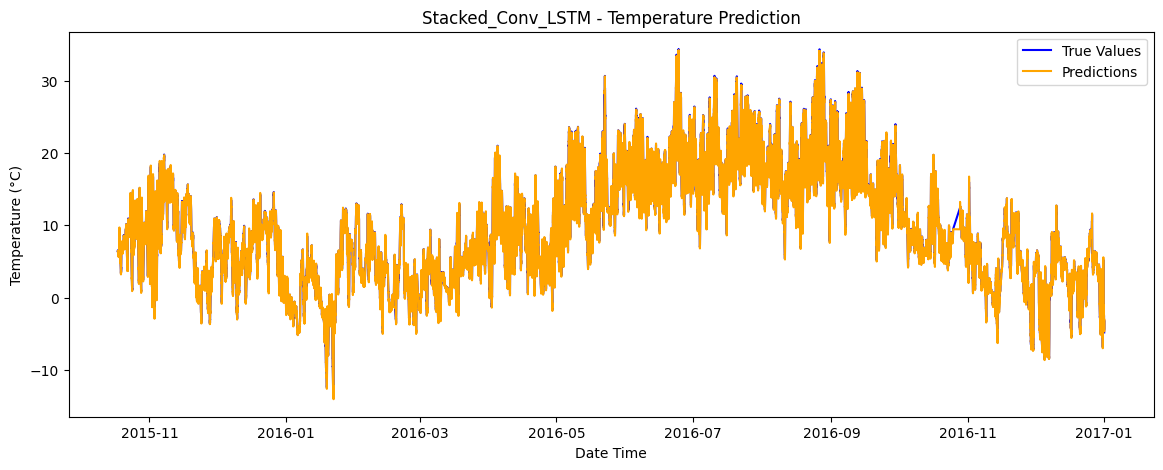

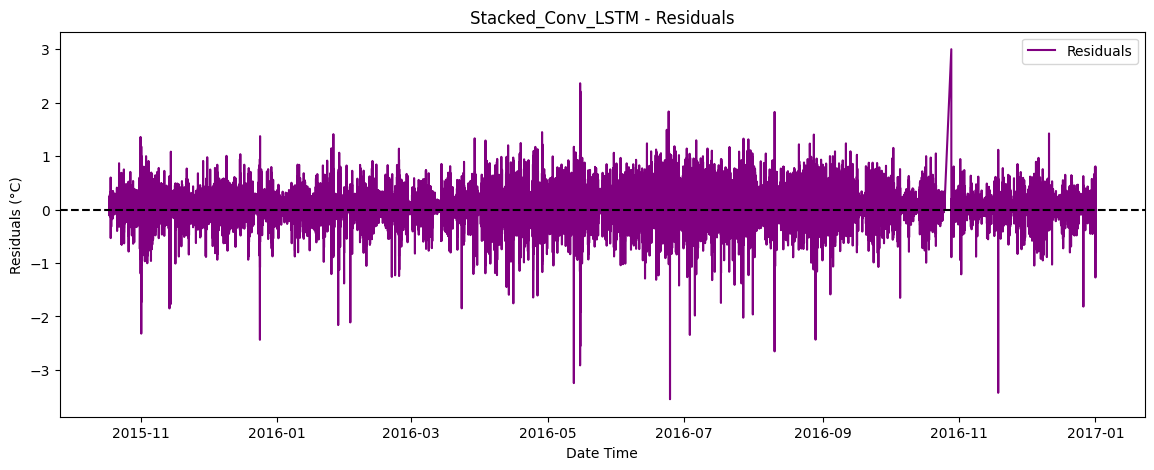

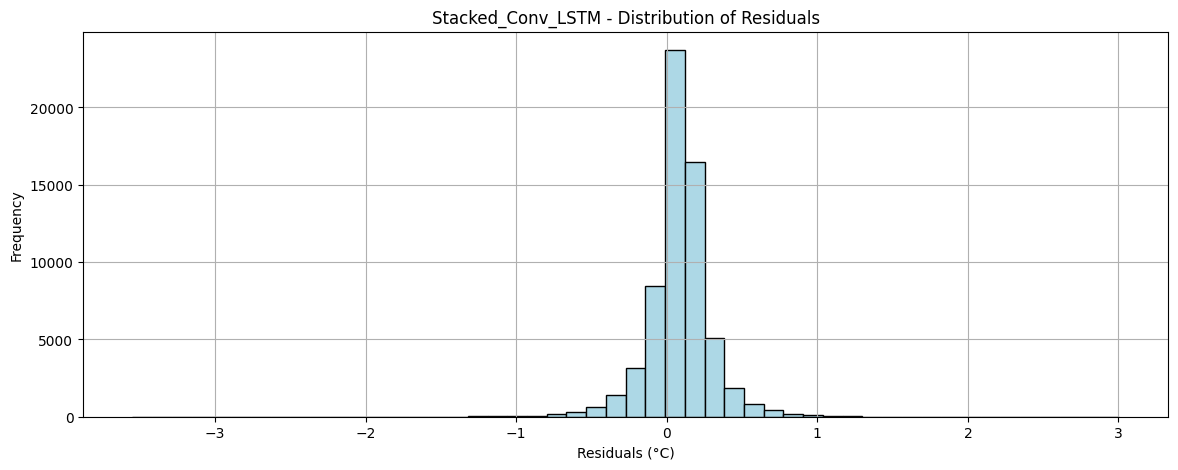

Stacked_Conv_LSTM MAE: 0.1624
Training Advanced_LSTM_with_Dropout model...
Epoch 1/5
9199/9199 ━━━━━━━━━━━━━━━━━━━━ 96s 10ms/step - loss: 0.0012 - val_loss: 2.5050e-05
Epoch 2/5
9199/9199 ━━━━━━━━━━━━━━━━━━━━ 88s 10ms/step - loss: 3.7990e-05 - val_loss: 1.2951e-05
Epoch 3/5
9199/9199 ━━━━━━━━━━━━━━━━━━━━ 141s 9ms/step - loss: 3.0471e-05 - val_loss: 1.2633e-05
Epoch 4/5
9199/9199 ━━━━━━━━━━━━━━━━━━━━ 142s 10ms/step - loss: 2.7372e-05 - val_loss: 1.7204e-05
Epoch 5/5
9199/9199 ━━━━━━━━━━━━━━━━━━━━ 143s 10ms/step - loss: 2.5713e-05 - val_loss: 1.4179e-05
1972/1972 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


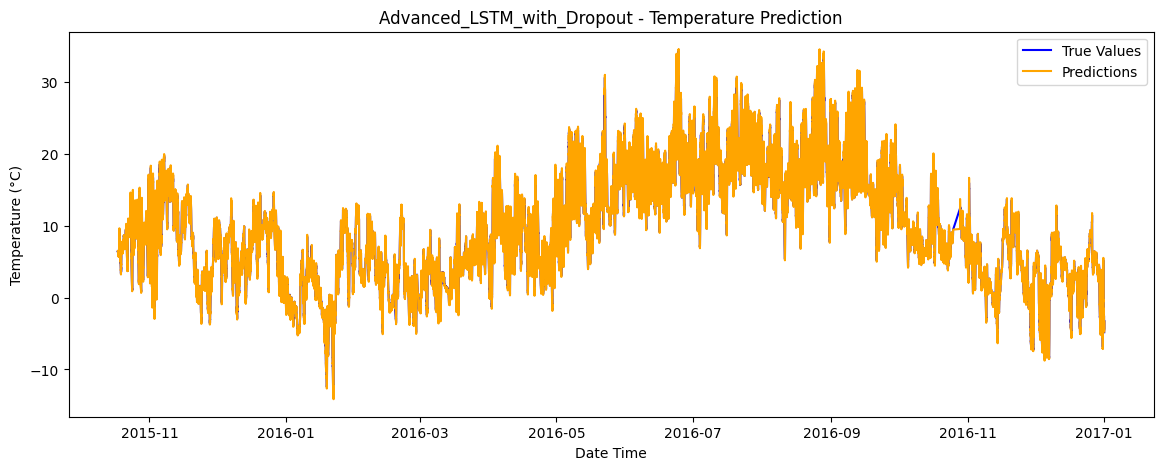

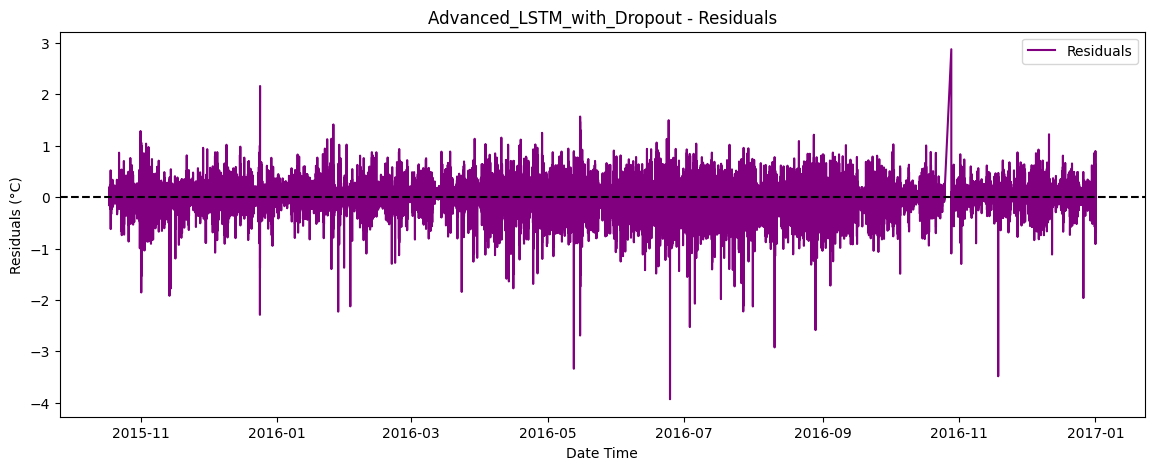

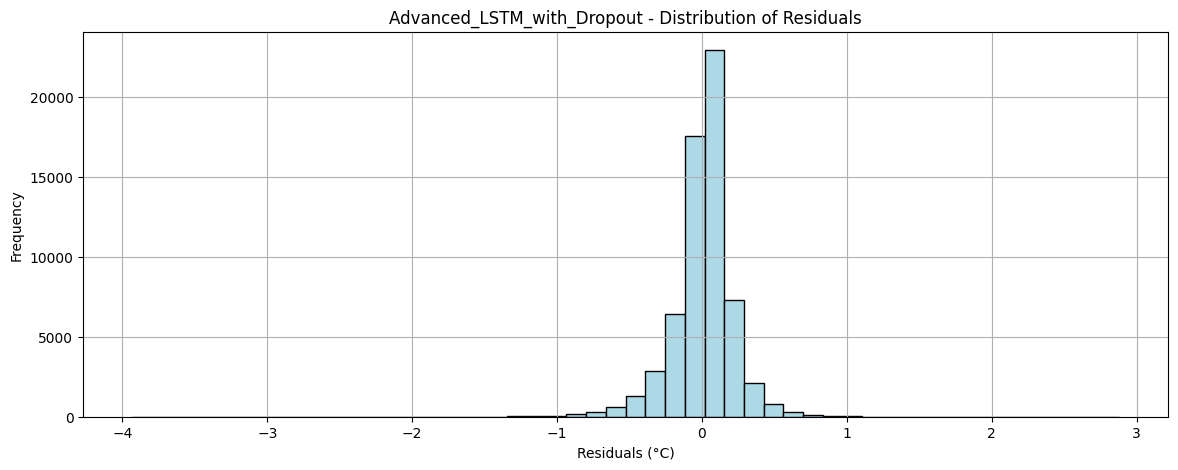

Advanced_LSTM_with_Dropout MAE: 0.1444
Training Advanced_Bidirectional_LSTM_with_Dropout model...
Epoch 1/5
9199/9199 ━━━━━━━━━━━━━━━━━━━━ 152s 16ms/step - loss: 8.6533e-04 - val_loss: 3.9261e-05
Epoch 2/5
9199/9199 ━━━━━━━━━━━━━━━━━━━━ 150s 16ms/step - loss: 3.8655e-05 - val_loss: 1.9457e-05
Epoch 3/5
9199/9199 ━━━━━━━━━━━━━━━━━━━━ 202s 16ms/step - loss: 2.8121e-05 - val_loss: 2.0239e-05
Epoch 4/5
9199/9199 ━━━━━━━━━━━━━━━━━━━━ 199s 16ms/step - loss: 2.5980e-05 - val_loss: 3.1008e-05
Epoch 5/5
9199/9199 ━━━━━━━━━━━━━━━━━━━━ 148s 16ms/step - loss: 2.4396e-05 - val_loss: 1.7915e-05
1972/1972 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step


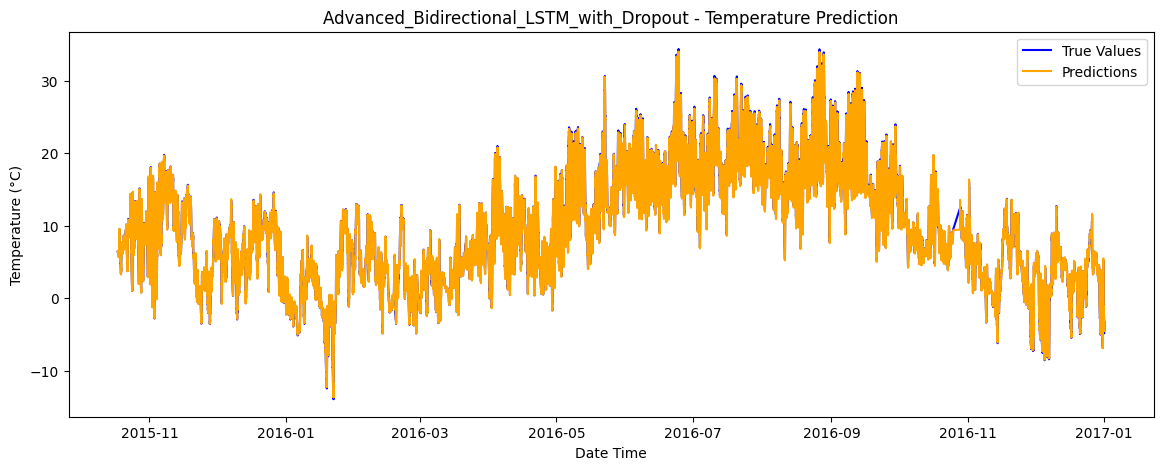

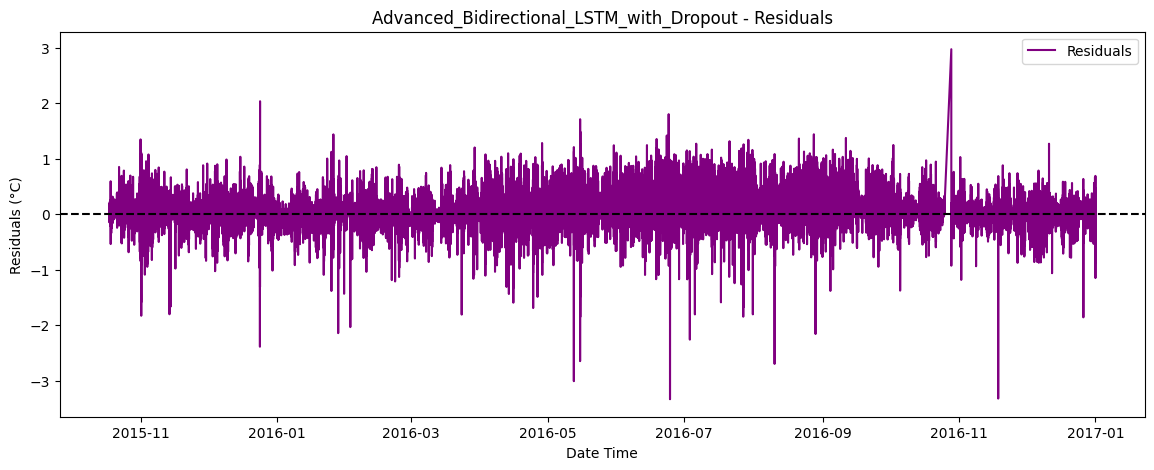

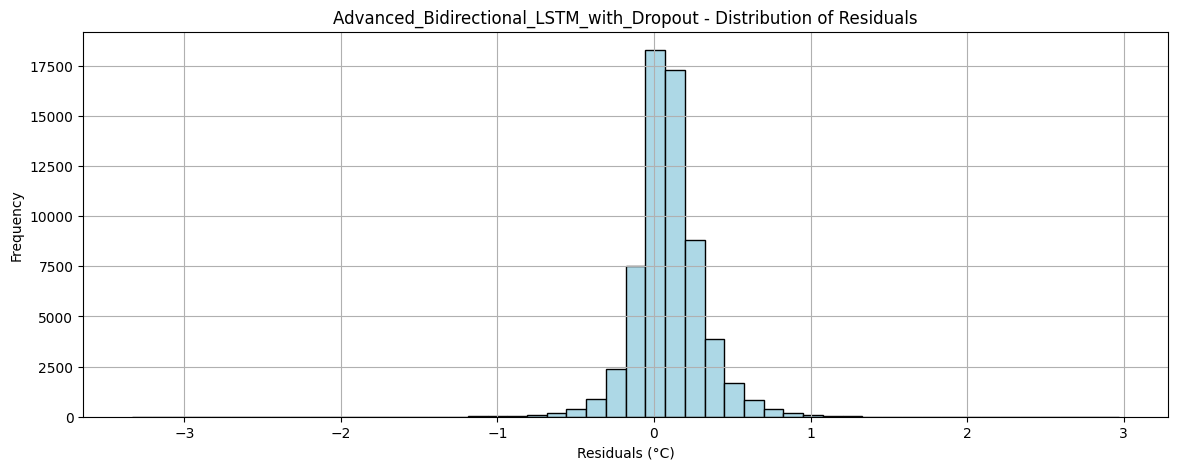

Advanced_Bidirectional_LSTM_with_Dropout MAE: 0.1692


In [14]:
# Compile and train all enhanced models
for model_name, model in models.items():
    model.compile(optimizer='adam', loss='mean_squared_error')
    mae = build_and_train_model(model_name, model)